# Stock Market Price Prediction 
### Using Recurrent Neural Network for Regression


In [2]:
#Importing all the required libraries
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import load_model
from sklearn.metrics import mean_squared_error
from tensorflow.keras import metrics
import matplotlib.pyplot as plt

In [3]:
# reading the dataset using pandas
dataset = pd.read_csv('data/q2_dataset.csv')

In [4]:
# Checking the content of the given dataset
dataset.head(5)

,Date,Close/Last,Volume,Open,High,Low
0,07/08/20,$381.37,29272970,376.72,381.50,376.36
1,07/07/20,$372.69,28106110,375.41,378.62,372.23
2,07/06/20,$373.85,29663910,370.00,375.78,369.87
3,07/02/20,$364.11,28510370,367.85,370.47,363.64
4,07/01/20,$364.11,27684310,365.12,367.36,363.91


In [5]:
 # we can see there are 6 columns/features and length of the data is given by
 print(len(dataset))
 dataset.tail(5)

1259


,Date,Close/Last,Volume,Open,High,Low
1254,07/15/2015,$126.82,33559770,125.72,127.15,125.58
1255,07/14/2015,$125.61,31695870,126.04,126.37,125.04
1256,07/13/2015,$125.66,41365600,125.03,125.76,124.32
1257,07/10/15,$123.28,61292800,121.94,123.85,121.21
1258,07/09/15,$120.07,78291510,123.85,124.06,119.22


The stock price dataset is for 5 years i.e from 07/09/15 to 07/08/20	

In [6]:
# Print the name of the colummns
dataset.columns

Index(['Date', ' Close/Last', ' Volume', ' Open', ' High', ' Low'], dtype='object')

In [7]:
# Selecting the required columns/features for the model
dataset_train=dataset.drop(['Date', ' Close/Last'], axis = 1)

In [8]:
dataset_train.head(5)

,Volume,Open,High,Low
0,29272970,376.72,381.50,376.36
1,28106110,375.41,378.62,372.23
2,29663910,370.00,375.78,369.87
3,28510370,367.85,370.47,363.64
4,27684310,365.12,367.36,363.91


In [9]:
# Creating the dataset by using the latest 3 days as the features and the next day’s opening price as the target
train = dataset_train.to_numpy()  #  Converting the dataframe to numpy array
x_train = []
y_train = []
# Creating the list with 3 days timestamp
for i in range(3, train.shape[0]):
    x_train.append(train[i-3:i])
    # selecting the next day opening price i.e. 2nd column in the dataset_train
    y_train.append(train[i, 1])

In [10]:
# Checking the shape of the x_train and y_train created using 3 day timestamp
x_train, y_train = np.array(x_train), np.array(y_train)
print(x_train.shape)
print(y_train.shape)

(1256, 3, 4)
(1256,)


Therefore, we have 3x4= 12 features i.e. 3 day timestamp data with each having 4 features(Volume,Open,High and Low)

y_train is having the opening price of the stock (target)

## Before any pre-processing, Creating the training and test dataset csv files


In [11]:
# Randomly spliting the dataset into 70% training and 30% testing

X_train, X_test, Y_train, Y_test = train_test_split(x_train, y_train, test_size = 0.30, random_state =30 )


In [12]:
# Checking the number of data in the training dataset
print(X_train.shape)
print(Y_train.shape)

(879, 3, 4)
(879,)


We can see that training dataset is having 879 entries i.e 70%. Each data point each with 3*4= 12 features and 879 corressponding target/label opening price

In [13]:
# Checking the number of entries in the testdataset
print(X_test.shape)
print(Y_test.shape)

(377, 3, 4)
(377,)


We can see that testing dataset is having 377 entries i.e 30%. Each data point each with 3*4= 12 features and 377 corressponding target/label opening price

# Storing the training dataset into train_data_RNN.csv


In [14]:
# X_train is 3D array. To store it in the csv flattening the array using 3 day timesteps features in the single row
flatten_train=[]
for i in range (X_train.shape[0]):
	    X=X_train[i].flatten()
	    flatten_train.append(X)
print(len(flatten_train))

879


In [15]:
# After flattening the list, converting it to dataframe to create the training dataset csv file
features_train= pd.DataFrame(data=flatten_train)
# y_train is having the target value(Opening price). It is already a 1D array so no need of flattening, converting into dataframe
target_train=pd.DataFrame(data=Y_train,columns=["Target"])
#Concatening the features with their corresponding target
training_dataset= pd.concat([features_train,target_train],axis=1)

# Training dataset is having 13 columns,
# 12 columns conatins features (open,low,high,volume) of 3 consecutive days 
# last columns is having target values i.e next day opening price

#storing the dataset in the train_data_RNN.csv file

training_dataset.to_csv("data/train_data_RNN.csv",index=False)

In [16]:
training_pandas = pd.read_csv("data/train_data_RNN.csv")
training_pandas.head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,Target
0,20544600.0,177.81,178.82,176.88,26575010.0,176.49,178.94,176.41,21561320.0,175.03,176.19,174.83,174.78
1,22267820.0,213.19,214.44,210.75,21564750.0,212.99,213.65,211.60,26919530.0,210.88,213.35,210.32,210.62
2,38018910.0,104.41,106.15,104.41,27697970.0,104.19,104.55,103.68,38771840.0,102.83,104.45,102.82,104.27
3,21329170.0,194.14,194.20,192.34,20912820.0,193.63,194.08,191.92,21535570.0,193.07,193.94,192.36,191.64
4,26356390.0,322.57,325.22,320.26,29706720.0,323.52,324.76,318.95,34154130.0,315.31,319.64,313.63,304.30


## Storing the test dataset into test_data_RNN.csv

In [17]:
# X_test is 3D array. To store it in the csv, flattening the array using 3 day timesteps features in the single row
flatten=[]
for i in range (X_test.shape[0]):
	    Y=X_test[i].flatten()
	    flatten.append(Y)
print(len(flatten))

377


In [18]:
# After flattening the list, converting it to dataframe to create the testing dataset csv file
features_test= pd.DataFrame(data=flatten)
# y_test is having the target value(Opening price). It is already a 1D array so no need of flattening, converting into dataframe
target_test=pd.DataFrame(data=Y_test,columns=["Target"])
#Concatening the features with their corresponding target
testing_dataset= pd.concat([features_test,target_test],axis=1)

# Training dataset is having 13 columns,
# 12 columns conatins features (Volume,Open,High and Low) of 3 consecutive days 
# last columns is havig target values i.e next day opening price

#storing the dataset in the train_data_RNN.csv file
testing_dataset.to_csv("data/test_data_RNN.csv",index=False)

In [19]:
testing_pandas=pd.read_csv("data/test_data_RNN.csv")
testing_pandas.head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,Target
0,25058280.0,101.91,102.91,101.78,27368840.0,102.24,102.28,101.50,33490630.0,101.41,102.24,100.15,101.31
1,32618140.0,107.27,108.85,107.20,32728460.0,107.40,107.72,106.45,47507230.0,107.28,107.37,105.57,108.91
2,32042290.0,95.94,96.29,95.25,29124140.0,96.25,96.89,95.35,35407050.0,94.94,96.35,94.68,96.00
3,29707270.0,113.06,114.31,112.63,21634520.0,112.71,113.05,112.28,36340670.0,112.46,113.37,111.80,113.16
4,84188210.0,228.08,228.50,212.61,100423300.0,247.18,251.83,228.00,67964260.0,247.39,252.84,242.61,239.77


# Builiding the  Model 

In [20]:
#Loading the dataset
training_dataset =pd.read_csv("data/train_data_RNN.csv")


In [21]:
# Pre-processing the training data, scaling the values between 0 and 1. 
# Min-Max Scaler is used to normalize the dataset, specially the column volume whose values are high. 
sc = MinMaxScaler(feature_range = (0, 1))
scaled_trainingDataset = sc.fit_transform(training_dataset)

In [22]:
scaled_trainingDataset.shape

(879, 13)

In [23]:
# Separating the features and the target values
X_train_data =scaled_trainingDataset[:,:12]
Y_train_data =scaled_trainingDataset[:,12]

# Reshaping the data 
X_train_data = X_train_data.reshape(-1,3,4)
Y_train_data = Y_train_data.reshape(-1,1)
print(X_train_data.shape)
print(Y_train_data.shape)

(879, 3, 4)
(879, 1)


In [26]:
# Initialising the RNN
regressor = Sequential()

# Adding the first LSTM layer
regressor.add(LSTM(units = 60, return_sequences =True, input_shape = (X_train_data.shape[1], 4)))

# Adding the second LSTM layer 
regressor.add(LSTM(units = 80))

# Adding the output layer
regressor.add(Dense(units = 1))

# Compiling the mode using adam optimizer and mean_squared_error for calculating loss
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [27]:
regressor.fit(X_train_data, Y_train_data, epochs = 50, batch_size=32)

Epoch 1/50
28/28 [==============================] - 8s 11ms/step - loss: 0.0673
Epoch 2/50
28/28 [==============================] - 0s 10ms/step - loss: 0.0039
Epoch 3/50
28/28 [==============================] - 0s 10ms/step - loss: 7.1260e-04
Epoch 4/50
28/28 [==============================] - 0s 10ms/step - loss: 5.6455e-04
Epoch 5/50
28/28 [==============================] - 0s 10ms/step - loss: 4.3609e-04
Epoch 6/50
28/28 [==============================] - 0s 10ms/step - loss: 3.2686e-04
Epoch 7/50
28/28 [==============================] - 0s 9ms/step - loss: 3.3573e-04
Epoch 8/50
28/28 [==============================] - 0s 10ms/step - loss: 2.6567e-04
Epoch 9/50
28/28 [==============================] - 0s 10ms/step - loss: 2.7105e-04
Epoch 10/50
28/28 [==============================] - 0s 10ms/step - loss: 2.6287e-04
Epoch 11/50
28/28 [==============================] - 0s 10ms/step - loss: 2.7197e-04
Epoch 12/50
28/28 [==============================] - 0s 10ms/step - loss: 3.3002e-0

In [28]:
# Saving the trained model
regressor.save("models/Group_27_RNN_model")

INFO:tensorflow:Assets written to: models/Group_27_RNN_model\assets


INFO:tensorflow:Assets written to: models/Group_27_RNN_model\assets


In [29]:
#Loading the trained model
regressor_Savedmodel=load_model("models/Group_27_RNN_model")

# Loading the testing data
test= pd.read_csv("data/test_data_RNN.csv")

# Normalization of the testing data
scaled_testDataset = sc.fit_transform(test)

X_test_data =scaled_testDataset[:,:12]
Y_test_data =scaled_testDataset[:,12]

# Reshaping the data 
X_test_data = X_test_data.reshape(-1,3,4)
Y_test_data = Y_test_data.reshape(-1,1)

#Run prediction on the test data 
predicted_stockPrice = regressor_Savedmodel.predict(X_test_data)
loss= mean_squared_error(Y_test_data,predicted_stockPrice)
print("The loss on test data is ",loss)

The loss on test data is  0.0004234322892940294


# Visualizing the results

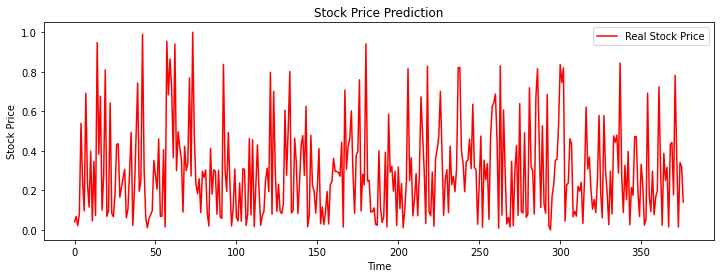

In [30]:
# Plotting the real stock price values
plt.figure(figsize=(12,4))
plt.plot(Y_test_data, color = 'red', label = 'Real Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

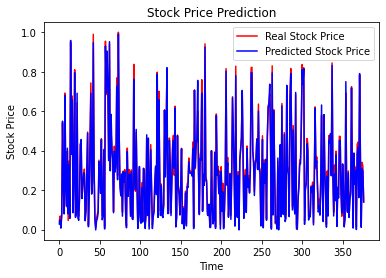

In [31]:
# Visulaizing the results , plotting the predicted and real stock price
plt.plot(Y_test_data, color = 'red', label = 'Real Stock Price')
plt.plot(predicted_stockPrice, color = 'blue', label = 'Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

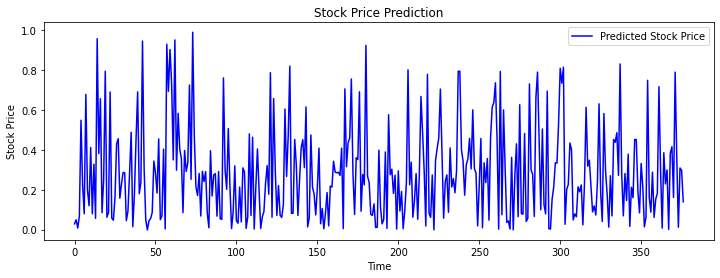

In [32]:
# Plotting the predicted stock prices
plt.figure(figsize=(12,4))
plt.plot(predicted_stockPrice, color = 'blue', label = 'Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

### Conclusion:




*    First, the given dataset for the stock price prediction was examined, the total number of rows, columns was analysed using pandas. It can be observed that dataset is containing stock prices of 5 years i.e. 07/09/15 to 07/08/20	with prices of 2020 year at the top. As mentioned, 4 features is considered using 3 consecutive days timestamp. Then the data was flattened and splitted randomly into 70% training and 30% testing data such that the 3 days features are considered as one row/data entry in the csv file. The training and testing data is stored in train_data_RNN.csv and test_data_RNN.csv files respectively.



*   MinMax scaler is used to normalize the data between 0 to 1 range.

*   To design the model for the stock prediction, networks with different layers were tried. Different combination of batch size, number of units in each layer was also tried.
 

*   The LSTM model is used for stock price prediction by using the given time series data set. The model is having 3 layer architecture with first layer having 60 units as an input layer, next layer has 80 units and the final output layer is having only 1 unit. The compiled using adam optimizer and mean square method is used to calculate the loss. The model is trained with 50 epochs and default 32 batch size is considered.



*   The final loss value after completing the 50 epochs is calculated using mean square error  . Intially the loss was high but then it fluctuates around 2.5. The final loss values indicates that the model is not overfitted.
*   The saved trained model is used to predict the stock prices. The individual plots for predicted stock prices and real prices is plotted. The final plot considering both real and predicted stock prices is showing that the model is well trained as indicated by the overlapping values of the predicted and real stock prices in the final plot.



*   Inreasing the number of days for the features will result in better understanding of the training data. Hence, the model will be trained better to predict the stock prices. For the high number of days timestamp, more dataset(entries) value should be considered for training the model.







### References:



*   https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.to_numpy.html




*   https://numpy.org/doc/stable/reference/generated/numpy.ndarray.flatten.html


*   https://www.tensorflow.org/guide/keras/save_and_serialize


*   https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.to_csv.html


*   https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html


*   https://www.tensorflow.org/guide/keras/rnn


*  https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html






